In [3]:
from hydra.utils import instantiate
import yaml
import torch
import numpy as np
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import RandomRotation, Pad, Resize, ToTensor, GaussianBlur
from PIL import Image

In [76]:
from aics_im2im.models.utils.mlflow import load_model_from_checkpoint

model = load_model_from_checkpoint("https://mlflow.a100.int.allencell.org", "08b6670f6b7f46a7b1cce70d00842c89"
                                  , path = "checkpoints/val loss/best.ckpt", strict=False)

In [77]:
device = "cuda:0"
model = model.to(device)
model = model.eval()

In [146]:
config = yaml.safe_load('''
_target_: aics_im2im.datamodules.DataframeDatamodule
_convert_: all

path: /allen/aics/modeling/ritvik/projects/tmp.csv
split_column: splits

batch_size: 64
num_workers: 1
multiprocessing_context: spawn
persistent_workers: true

transforms:
  - _target_: aics_im2im.dataframe.transforms.GroupCols
    groups:
      image: sdf_path_align_3dnuc
      cell_id: CellId
  - _target_: aics_im2im.image.io.ReadNumpyFile
    keys: image
    remote: false
  - _target_: monai.transforms.NormalizeIntensityd
    keys: [image]
    subtrahend: 6
  - _target_: monai.transforms.ToTensord
    keys: [image]
    track_meta: false

''')

In [ ]:
data = instantiate(config)
train_dl = data.train_dataloader()
batch = next(iter(train_dl))

In [ ]:
for i in range(10):
    print(batch['image'][i].min(), batch['image'][i].max(), batch['image'][i].mean())

In [79]:
import pytorch_lightning as pl
pl.seed_everything(42)

def rotate(matrix, deg_angle, axis):
    d = len(matrix)
    h = len(matrix[0])
    w = len(matrix[0][0])
    min_new_x = 0
    max_new_x = 0
    min_new_y = 0
    max_new_y = 0
    min_new_z = 0
    max_new_z = 0
    new_coords = []
    angle = radians(deg_angle)

    for z in range(d):
        for y in range(h):
            for x in range(w):

                new_x = None
                new_y = None
                new_z = None

                if axis == "x":
                    new_x = int(round(x))
                    new_y = int(round(y*cos(angle) - z*sin(angle)))
                    new_z = int(round(y*sin(angle) + z*cos(angle)))
                elif axis == "y":
                    new_x = int(round(z*sin(angle) + x*cos(angle)))
                    new_y = int(round(y))
                    new_z = int(round(z*cos(angle) - x*sin(angle)))
                elif axis == "z":
                    new_x = int(round(x*cos(angle) - y*sin(angle)))
                    new_y = int(round(x*sin(angle) + y*cos(angle)))
                    new_z = int(round(z))

                val = matrix.item((z, y, x))
                new_coords.append((val, new_x, new_y, new_z))
                if new_x < min_new_x: min_new_x = new_x
                if new_x > max_new_x: max_new_x = new_x
                if new_y < min_new_y: min_new_y = new_y
                if new_y > max_new_y: max_new_y = new_y
                if new_z < min_new_z: min_new_z = new_z
                if new_z > max_new_z: max_new_z = new_z

    new_x_offset = abs(min_new_x)
    new_y_offset = abs(min_new_y)
    new_z_offset = abs(min_new_z)

    new_width = abs(min_new_x - max_new_x)
    new_height = abs(min_new_y - max_new_y)
    new_depth = abs(min_new_z - max_new_z)

    rotated = np.empty((new_depth + 1, new_height + 1, new_width + 1))
    rotated.fill(0)
    for coord in new_coords:
        val = coord[0]
        x = coord[1]
        y = coord[2]
        z = coord[3]

        if rotated[new_z_offset + z][new_y_offset + y][new_x_offset + x] == 0:
            rotated[new_z_offset + z][new_y_offset + y][new_x_offset + x] = val

    matrix = rotated
    return matrix

Global seed set to 42


In [80]:
x.shape

torch.Size([1, 32, 32, 32])

In [115]:
from math import radians, cos, sin
import torchio

x =  batch['image'][2]

# x =  dl['image'][0]
in_x_2 = x.cpu().numpy()


totensor = ToTensor()
size =32
resize = torchio.transforms.Resize(target_shape=32)

all_x_r = []
for channel in range(1):
    in_x = in_x_2[channel]
    x_r = np.concatenate((
        resize(np.expand_dims(rotate(in_x, 0*90, 'z'), axis=0)),
#         resize(np.expand_dims(rotate(in_x, 0.5*90, 'z'), axis=0)),
        resize(np.expand_dims(rotate(in_x, 1*90, 'z'), axis=0)),
#         resize(np.expand_dims(rotate(in_x, 1.5*90, 'z'), axis=0)),
        resize(np.expand_dims(rotate(in_x, 2*90, 'z'), axis=0)),
#         resize(np.expand_dims(rotate(in_x, 2.5*90, 'z'), axis=0)),
        resize(np.expand_dims(rotate(in_x, 3*90, 'z'), axis=0)),
#         resize(np.expand_dims(rotate(in_x, 3.5*90, 'z'), axis=0))
), axis=0)
    all_x_r.append(x_r)
all_x_r = np.stack(all_x_r, axis=1) 
all_x_r = torch.tensor(all_x_r)

In [116]:
all_x_r = all_x_r.float()

In [117]:
all_x_r.shape

torch.Size([4, 1, 32, 32, 32])

In [118]:
tmp.shape

torch.Size([4, 87808])

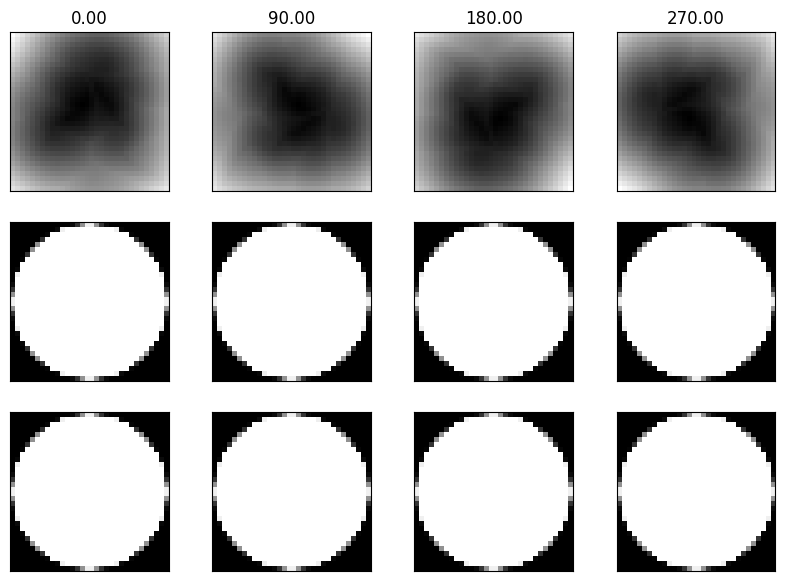

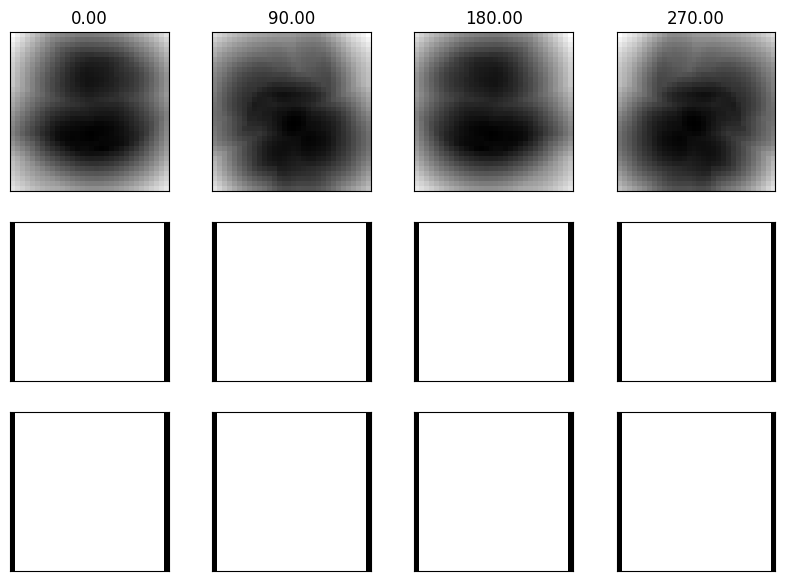

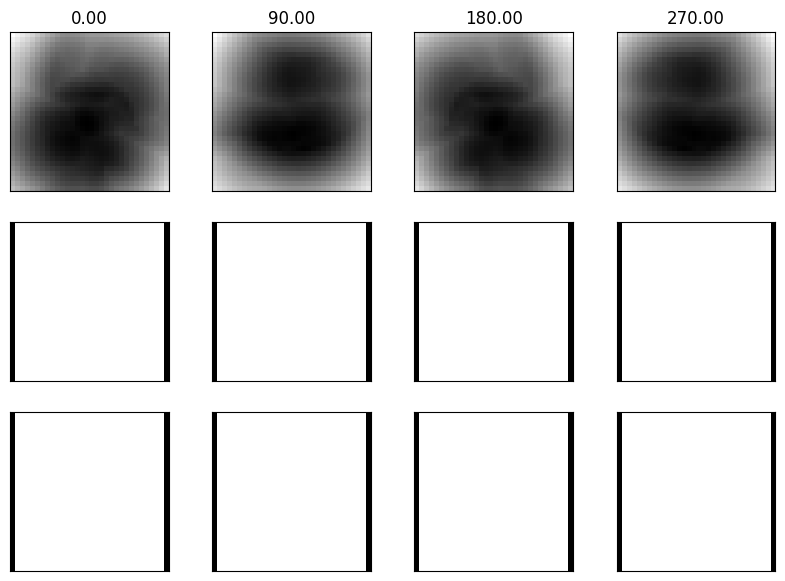

In [119]:

device = "cuda:0"
all_x_r = {'image': all_x_r.to(device)}

model.to(device)
with torch.no_grad():
    y, _, z_parts_params_1, _ = model(all_x_r, do_rot=False, decode=True, compute_loss=False)
    y2, _, z_parts_params_2, _ = model(all_x_r, do_rot=True, decode=True, compute_loss=False)
    y = y['image'].cpu().numpy()
    y2 = y2['image'].cpu().numpy()
    if 'angle' in z_parts_params_1.keys():
        rot_1 = z_parts_params_1['angle'].cpu().numpy()
        rot_2 = z_parts_params_2['angle'].cpu().numpy()


for proj in [0]:
    for j in [0, 1, 2]:

        fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(10, 7))
#         theta = torch.Tensor([0, 0.5*90, 1*90, 1.5*90, 2*90, 2.5*90, 3*90, 3.5*90])
        theta = torch.Tensor([0,  1*90,  2*90, 3*90])
        for i in range(len(theta)):
            ax[0, i].imshow(all_x_r['image'][i][proj].max(j)[0].detach().cpu().numpy(), cmap="gray")
            ax[1, i].imshow(y[i][proj].max(j), cmap="gray")
            ax[2, i].imshow(y2[i][proj].max(j), cmap="gray")
            ax[0, i].set_title("%.2f" % (theta[i].numpy()))
        plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
        plt.show()

In [121]:
y.shape

(4, 1, 32, 32, 32)

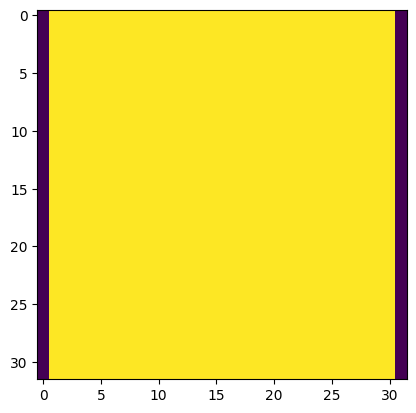

In [124]:
plt.imshow(y[0][0].max(2))

In [112]:
all_x_r['image'].shape

torch.Size([4, 1, 32, 32, 32])

In [76]:
import numpy as np
from meshpy.tet import MeshInfo, build
import numpy as np
from ipygany import Scene, TetraMesh
import numpy as np
import mcubes


def export_mesh(img_in, filename):
    # Extract the 0-isosurface
    # vertices, triangles = mcubes.marching_cubes(img3,0.5)
    vertices, triangles = mcubes.marching_cubes(img_in,0.5)

    # Export the result to sphere.dae
    # mcubes.export_mesh(vertices, triangles, "sphere.dae", "MySphere")
    mcubes.export_obj(vertices, triangles, f'meshes/{filename}.obj')

    vert_list = []
    for i in range(vertices.shape[0]):
        vert_list.append(list(vertices[i]))
    triangles_list = []
    for i in range(triangles.shape[0]):
        triangles_list.append(list(triangles[i]))

    mesh_info = MeshInfo()
    mesh_info.set_points(vert_list)
    mesh_info.set_facets(triangles_list)
    mesh = build(mesh_info)

    # Normalize mesh for viz

    norm_verts = (vertices - vertices.mean(axis=0))/(vertices.std(axis=0))

    vert_list = []
    for i in range(vertices.shape[0]):
        vert_list.append([list(norm_verts[i])[2], list(norm_verts[i])[1], list(norm_verts[i])[0]])
    triangles_list = []
    for i in range(triangles.shape[0]):
        triangles_list.append(list(triangles[i]))
    vertices_norm = np.stack(vert_list, axis=0)
    mcubes.export_obj(vertices_norm, triangles, f'meshes/{filename}_norm.obj')

In [77]:
all_x_r['image'].shape

torch.Size([4, 2, 28, 28, 28])

In [78]:
# ind = 3
ind = 3
img_in = all_x_r['image'][ind][0].detach().cpu().numpy()
img_recon = y[ind][0]
img_recon2 = y2[ind][0]

In [79]:
export_mesh(img_in, 'input')
export_mesh(img_recon, 'recon_inv')
export_mesh(img_recon2, 'recon')

In [80]:
for ind in range(4):
    for channel in range(2):
        img_in = all_x_r['image'][ind][channel].detach().cpu().numpy()
        img_recon = y[ind][channel]
        img_recon2 = y2[ind][channel]
        export_mesh(img_in, f'input_chan_{channel}_rot_{ind}')
        export_mesh(img_recon, f'recon_inv_chan_{channel}_rot_{ind}')
        export_mesh(img_recon2, f'recon_chan_{channel}_rot_{ind}')

2022-11-28 00:00:01,591	WARNING worker.py:1829 -- The log monitor on node prd-aics-dcp-038 failed with the following error:
Traceback (most recent call last):
  File "/home/ritvik.vasan/.cache/pypoetry/virtualenvs/aics-latent-spaces-XUDj-riv-py3.9/lib/python3.9/site-packages/ray/_private/log_monitor.py", line 520, in <module>
    log_monitor.run()
  File "/home/ritvik.vasan/.cache/pypoetry/virtualenvs/aics-latent-spaces-XUDj-riv-py3.9/lib/python3.9/site-packages/ray/_private/log_monitor.py", line 436, in run
    anything_published = self.check_log_files_and_publish_updates()
  File "/home/ritvik.vasan/.cache/pypoetry/virtualenvs/aics-latent-spaces-XUDj-riv-py3.9/lib/python3.9/site-packages/ray/_private/log_monitor.py", line 339, in check_log_files_and_publish_updates
    file_info.reopen_if_necessary()
  File "/home/ritvik.vasan/.cache/pypoetry/virtualenvs/aics-latent-spaces-XUDj-riv-py3.9/lib/python3.9/site-packages/ray/_private/log_monitor.py", line 79, in reopen_if_necessary
    new